In [1]:
import cv2
import numpy as np, matplotlib.pyplot as plt
from cvflow import *
import laneFindingPipeline, utils
%matplotlib inline

In [23]:
from utils import show

In [12]:
allFrames = laneFindingPipeline.utils.loadFrames()#maxframes=100)

HBox(children=(IntProgress(value=0, description='load project: ', max=1260), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load challenge: ', max=484), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load harder_challenge: ', max=1199), HTML(value='')))

In [18]:
Blur?

In [34]:
class HSVshow(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        undistort = Undistort(self.input)
        perspective = Perspective(undistort)
        hsv = CvtColor(perspective, cv2.COLOR_RGB2HSV)
        s, v = [ColorSplit(hsv, k) for k in range(1, 3)]
#         s_binary = CountSeekingThreshold(s, goalCount=11000)
#         v_binary = CountSeekingThreshold(v, goalCount=11000)
        s_sharp = UnsharpMask(s)
        s_binary = SobelClip(
            s_sharp, narrowIterations=10, wideIterations=20, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=13000,
            )
        )
        
        convv = Convolve(v, kernel=20)
        blurv = Blur(v, ksize=21)
#         deEmphasized = v / blurv
        
        v_binary = SobelClip(
            v, narrowIterations=10, wideIterations=20, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=19000,
            )
        )        
        self.output = s_binary | v_binary
        self.includeInMultistep([
            undistort, perspective, hsv, s, v, #h,
            #convv,
            blurv, #deEmphasized,
            s_sharp,
            s_binary, v_binary,
        ])

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

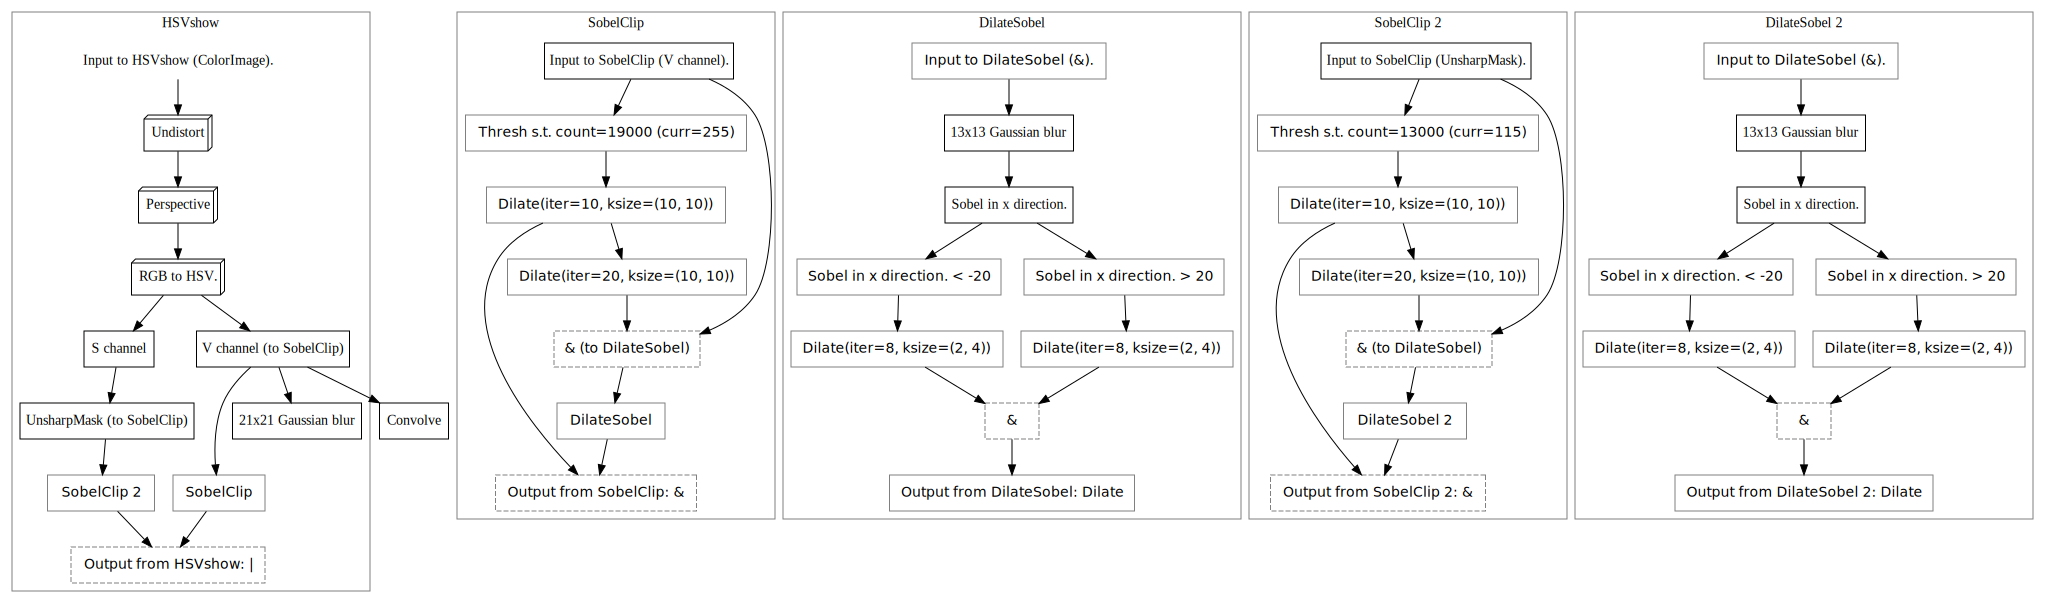

In [35]:
frame = allFrames['harder_challenge'][-12]
hsvshow = HSVshow()
hsvshow(frame)
hsvshow.assembleGraph()
hsvshow.draw(addKey=False)

In [90]:
v_channel.getSimpleName()

'S channel'

In [101]:
v_channel = [
    channel for channel in hsvshow.getByKind(ColorSplit)
    if 'V channel' in channel.getSimpleName()
][0]

In [104]:
blur = [child for child in v_channel.children if isinstance(child, Blur)][0]

In [106]:
convolve = list(hsvshow.getByKind(Convolve))[0]

5667
0


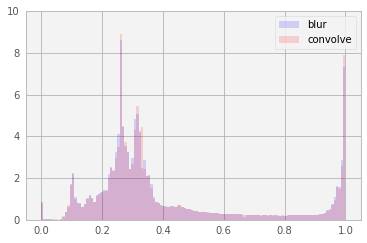

In [108]:
fig, ax = plt.subplots()

alpha = .15
x = blur.value.ravel().astype('float')
print((x==0).sum())
x /= x.max()
ax.hist(x, bins=128, label='blur', color='blue', alpha=alpha, normed=True)

x = convolve.value.ravel()
print((x==0).sum())
x /= x.max()
ax.hist(x, bins=128, label='convolve', color='red', alpha=alpha, normed=True)
ax.set_ylim(0, 10)
ax.legend();

In [14]:
# convolve = list(hsvshow.getByKind(Convolve))[0]
# show(convolve.value)

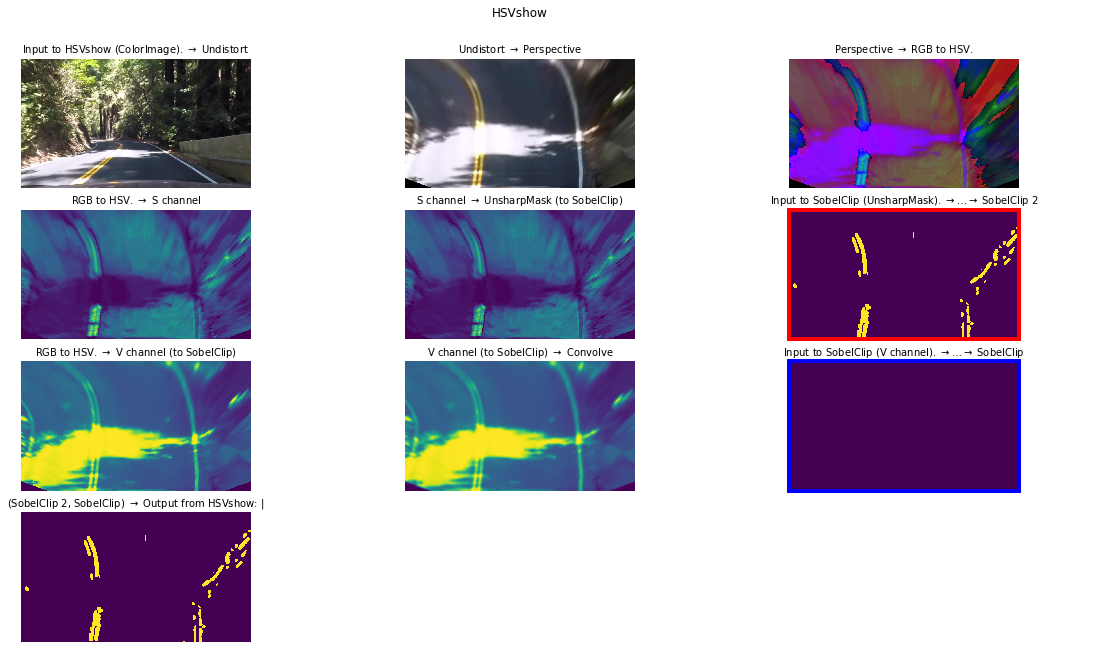

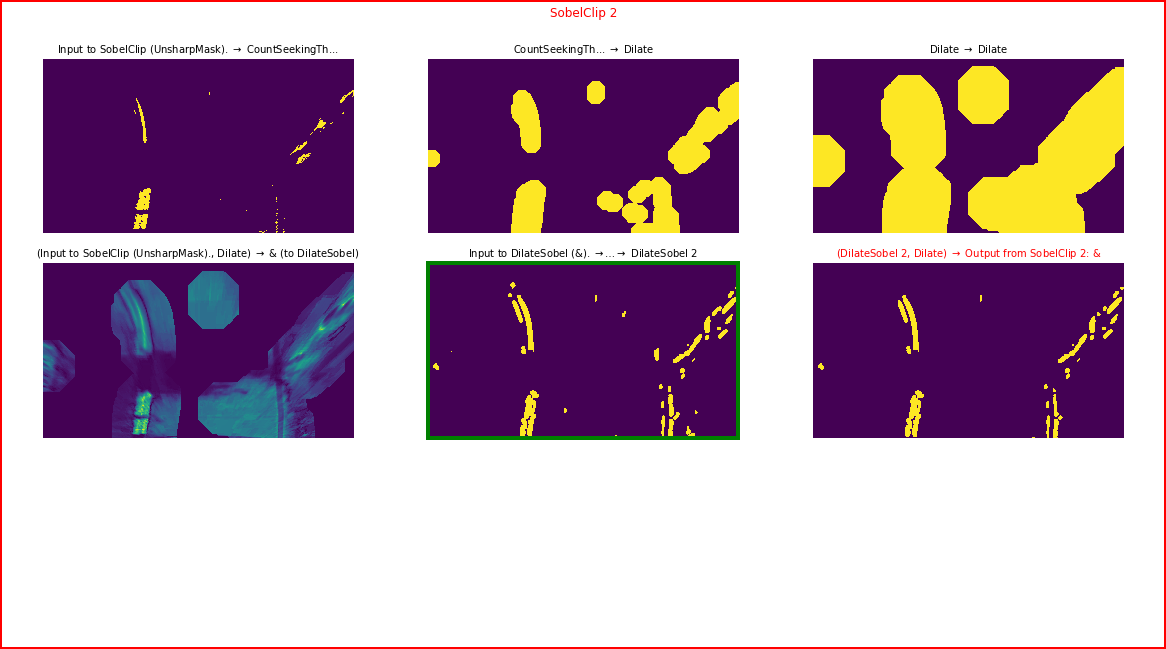

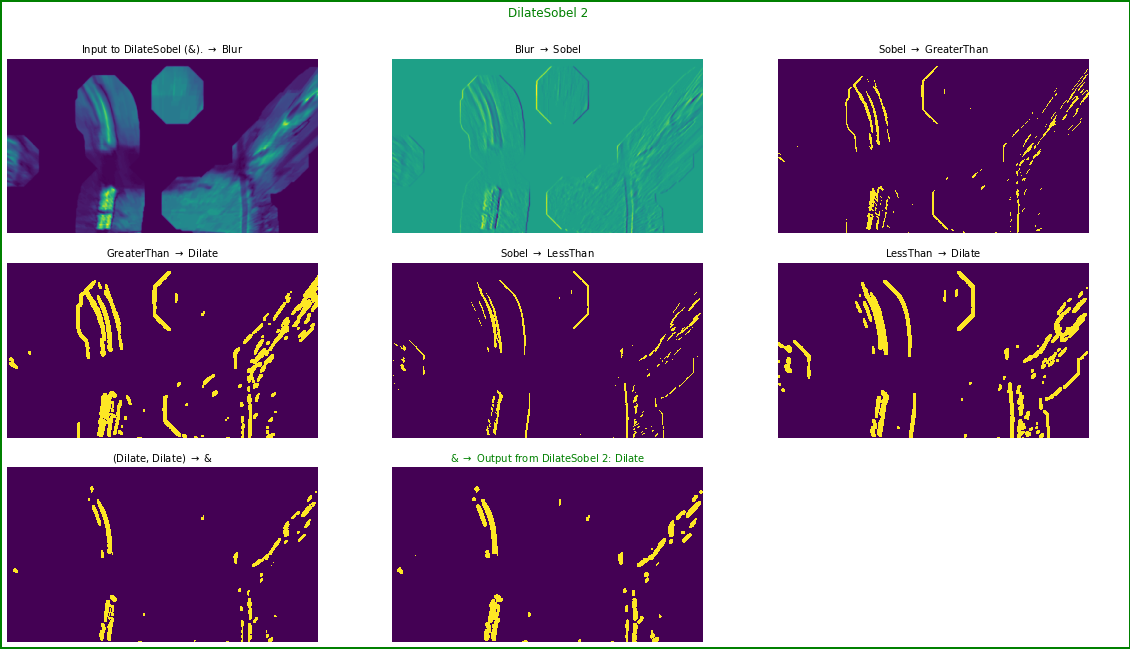

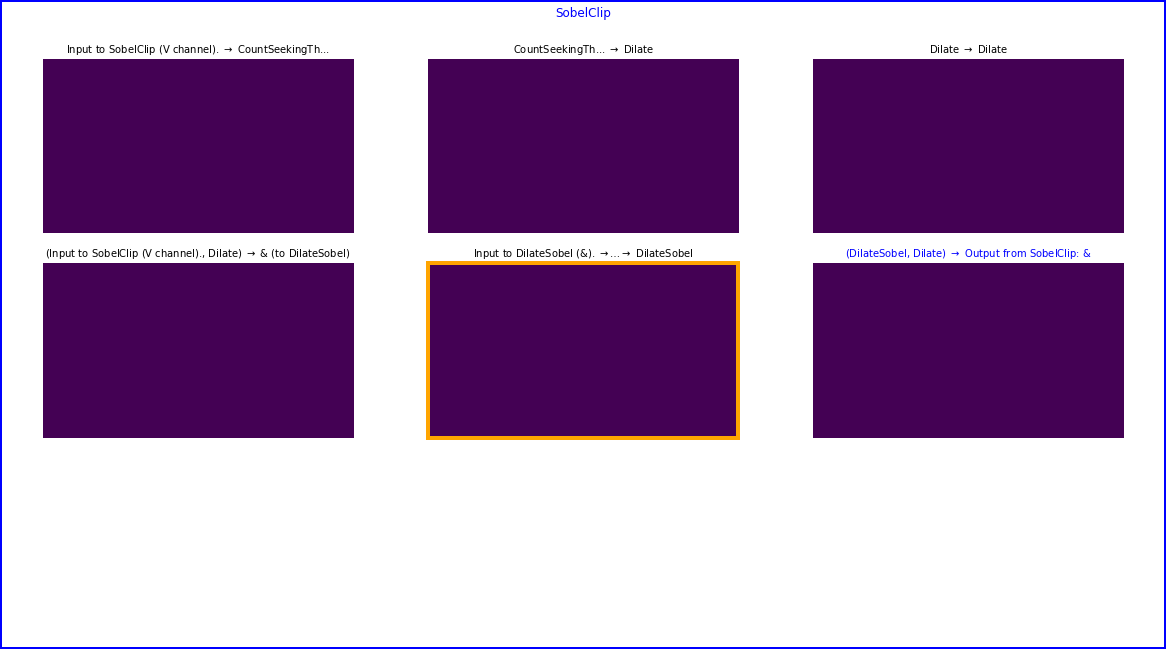

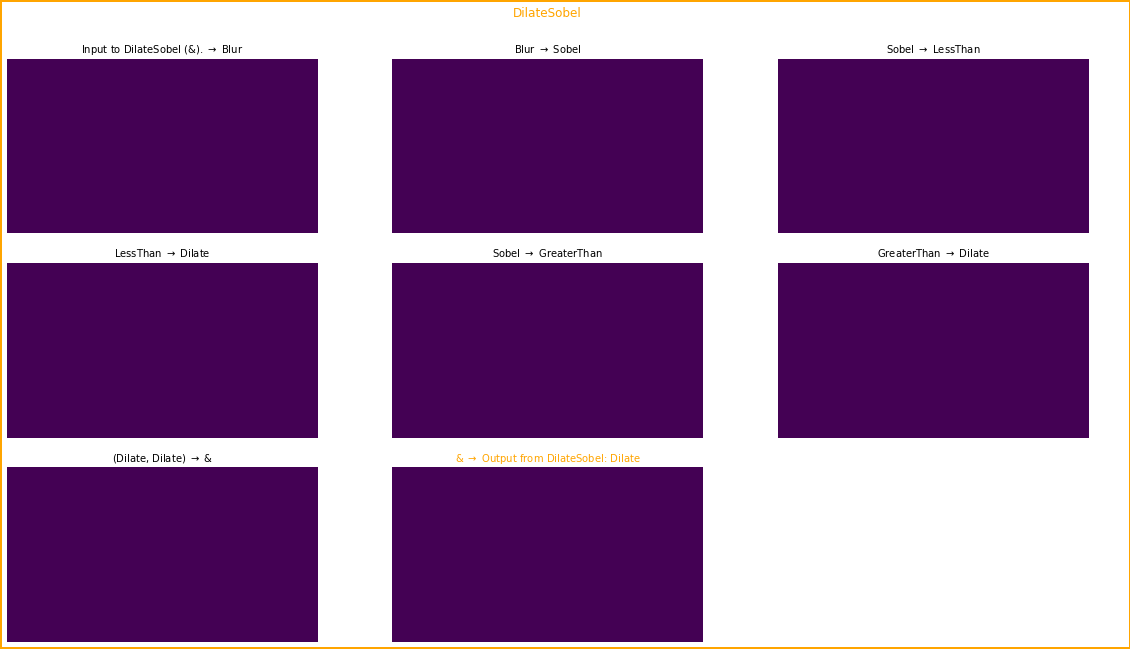

In [17]:
hsvshow.showMembers(
    subplotKwargs=dict(figsize=(16,9)), 
    wspace=0, showMultistepParents=True
)